In [3]:
from urllib.request import urlopen
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import ttest_ind
from wordcloud import WordCloud, STOPWORDS

import os
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *

OFF_API_PATH = "https://world.openfoodfacts.org/{}.json"
OFF_API_QUERY_PATH = "https://world.openfoodfacts.org/cgi/search.pl?{}&page_size=1000&action=process&json=1"
figsize=(12, 10)

dfConso = pd.read_csv("../data/Table_conso.csv", sep=";", encoding="ansi")
dfIndiv = pd.read_csv("../data/Table_indiv.csv", sep=";", encoding="ansi")
dfCapiCA = pd.read_csv("../data/Table_capi_ca.csv", sep=";", encoding="ansi")
dfCarnetCA = pd.read_csv("../data/Table_carnet_ca_1.csv", sep=";", encoding="ansi")
dfIndivCA = pd.read_csv("../data/Table_indiv_ca.csv", sep=";", encoding="ansi")
dfIndnut = pd.read_csv("../data/Table_indnut.csv", sep=";", encoding="ansi")
dfMenage = pd.read_csv("../data/Table_menage_1.csv", sep=";", encoding="ansi")
dfRepas = pd.read_csv("../data/Table_repas.csv", sep=";", encoding="ansi")
dfNomenclature = pd.read_csv("../data/Nomenclature_3.csv", sep=";", encoding="ansi")
dfCorrespondance = pd.concat([pd.read_csv("../data/correspondance_reponses.csv", sep=";", encoding="ansi"), pd.read_csv("../data/correspondance_custom.csv", sep=";", encoding="ansi")])
dfDataNames = pd.concat([pd.read_csv("../data/Data_names_all.csv", sep=";", encoding="ansi"), pd.read_csv("../data/Data_names_custom.csv", sep=";", encoding="ansi")])
dfValRef = pd.read_csv("../data/Valeurs_References.csv", sep=";", encoding="ansi")

# dfCorrespondance = pd.read_csv("../data/correspondance_reponses.csv", sep=";", encoding="ansi")
# dfDataNames = pd.read_csv("../data/Data_names_all.csv", sep=";", encoding="ansi")

C:\Users\josep\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (150,151,152,153,154,155) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Sources pour les valeurs de références

http://www.efsa.europa.eu/sites/default/files/2017_09_DRVs_summary_report.pdf

https://www.anses.fr/fr/system/files/NUT2012SA0103Ra-1.pdf

https://fr.wikipedia.org/wiki/Apports_journaliers_recommand%C3%A9s

Table_capi_ca.csv
Table_carnet_ca_1.csv
Table_conso.csv
Table_indiv.csv
Table_indiv_ca.csv
Table_indnut.csv
Table_menage_1.csv
Table_repas.csv
correspondance_reponses.csv

In [4]:
dfCorrespondance.head(10)

,Libellé du codage,code,Signification
0,a5gglo,1,rural
1,a5gglo,2,2 000 à 20 000 hab.
2,a5gglo,3,20 000 à 100 000 hab.
3,a5gglo,4,> 100 000 hab
4,a5gglo,5,agglo paris
5,a9gglo,1,rural
6,a9gglo,2,2 000 à 5 000 hab.
7,a9gglo,3,5 000 à 10 000 hab.
8,a9gglo,4,10 000 à 20 000 hab.
9,a9gglo,5,20 000 à 50 000 hab.


In [5]:
dfDataNames.head(5)

,Nom de la variable,Type,Libellé du codage,Libellé de la variable
0,achapub,Numérique,pub,Demande à acheter des produits pour lesquels i...
1,achpub1,Numérique,achpub,A acheté Aliment 1 - Publicité
2,achpub2,Numérique,achpub,A acheté Aliment 2 - Publicité
3,achpub3,Numérique,achpub,A acheté Aliment 3 - Publicité
4,achpub4,Numérique,achpub,A acheté Aliment 4 - Publicité


In [6]:
dfDataCorrespondance = dfDataNames.merge(dfCorrespondance,left_on="Libellé du codage", right_on="Libellé du codage", how="inner")

In [7]:
def findCorrespondance(val, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    try:
        meaning = dfDataCorrespondance[(dfDataCorrespondance["Nom de la variable"] == column) & (dfDataCorrespondance["code"] == val)]["Signification"].values[0]
    except IndexError:
        meaning = val
    return meaning

def mapCorrespondances(vals, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    return [findCorrespondance(val, column) for val in vals]

def findDescription(column):
    """
    Returns the description of the column signification.
    """
    return dfDataNames[(dfDataNames["Nom de la variable"] == column)]["Libellé de la variable"].values[0]

def mapDescription(columns):
    """
    Returns the description of the columns signification.
    """
    return [findDescription(column) for column in columns]

In [8]:
dfIndivO18 = dfIndiv[dfIndiv["tage"]>=4]
dfIndivO18.loc[:, "sexeps"]= dfIndivO18["sexeps"].values.astype(int)
print(mapCorrespondances([i for i in range(4, 9)], "tage"))
dfIndivO18.head()

['18-24 ans', '25-34 ans', '35-49 ans', '50-64 ans', '65 ans et +']


C:\Users\josep\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,sexeps,fqcantine,entrerep,colmata,distrib,distconf,distfruit,distsoli,fastfood,ffrepas,...,peaupoulet,grasjambon,peaupommes,typelait,suc_yao,suc_froblanc,suc_suisse,suc_cafe,suc_the,suc_boischoc
0,2,9.0,4.0,4.0,5.0,NaN,NaN,NaN,6.0,1.0,...,1,1,1,3,4,1,1,5,4,5
1,1,9.0,4.0,5.0,4.0,2.0,2.0,2.0,6.0,1.0,...,2,2,2,2,4,4,5,1,1,5
2,2,9.0,5.0,4.0,5.0,NaN,NaN,NaN,7.0,NaN,...,2,2,2,6,3,3,5,3,3,5
3,2,9.0,2.0,3.0,5.0,NaN,NaN,NaN,7.0,NaN,...,2,2,2,6,1,1,1,1,5,5
4,2,9.0,2.0,1.0,5.0,NaN,NaN,NaN,1.0,1.0,...,2,2,1,2,5,5,5,1,1,5


In [9]:
# Group CSP
# new_category (code) = {old_cat_A (code), old_cat_B (code), ...}
# agriculteur (1) = {agriculteur (1)}
# artisan, commerçant, chef d'entreprise (2) = {artisan (2), commerçant (3), chef d'entreprise (4), profession libérale (5)}
# cadre, prof. intellect. sup. (3) = {cadre, prof. intellect. sup. (6)}
# profession intermédiaire (4) = {contremaître, agent de maitrise (7), technicien (8), autre prof. intermédiaire (9)}
# employé (5) = {employé (10)}
# ouvrier (6) = {ouvrier qualifié (11), ouvrier non qualifié (12)}
# retraité (7) = {retraité(e), pré-retraité(e) (16), retiré des affaires (ancien agri., art.) (17)}
# inactif (8) = {chômeur inscrit ou non à l'anpe (14), etudiant-élève-formation-stage non rémunéré (15), femme ou homme au foyer (18), autre inactif (pension de réversion, invalidité) (19)}
# refus (0) = {refus (13), [refus] (20)}

cspiToCspi2_dict = {1: [1], 2: [2, 3, 4, 5], 3: [6], 4: [7, 8, 9], 5: [10], 6: [11, 12], 7: [16, 17], 8: [14, 15, 18, 19], 0: [13, 20]}

def cspiToCspi2(code):
    for k in cspiToCspi2_dict.keys():
        if code in cspiToCspi2_dict[k]:
            return(k)

serieCspi2 = dfIndivO18["cspi"].apply(lambda x : cspiToCspi2(x))
dfIndivO18 = dfIndivO18.assign(cspi2=serieCspi2)

# Remove the only one "refus"
dfIndivO18 = dfIndivO18[dfIndivO18['cspi2'] != 0]

## Explore the data
### INCA2

In [10]:
def countDistribution(varOfInterest):
    countVOI = dfIndivO18[[varOfInterest]].groupby(varOfInterest)\
                                        .agg({varOfInterest:"count"})
    countVOI.index = mapCorrespondances(countVOI.index, varOfInterest)
    print(countVOI)

In [11]:
countDistribution('cspi2')
# countDistribution('cspi2')
# countDistribution('agglo9')
# countDistribution('tage')

print("Age moyen des adultes interrogés : {:.1f} ans".format(dfIndivO18['v2_age'].mean()))

                                        cspi2
agriculteur                                37
artisan, commerçant, chef d'entreprise     99
cadre, prof. int. sup.                    211
profession intermédiaire                  430
employé                                   587
ouvrier                                   316
retraité                                  550
inactif                                   393
Age moyen des adultes interrogés : 45.8 ans


In [12]:
def exploreNut_compareMeans(varOfInterest):
    """Probably very similar to plotMeanValues()."""
    dfNutIndivO18 = dfIndnut.merge(dfIndivO18, left_on="nomen", right_on="nomen", how="inner")
    numFeatures = ["nutj{}".format(i) for i in range(4, 29)]\
                + ["nutj{}".format(i) for i in range(30, 40)]
#                 + ["poidsm", "taille", "tele", "intense_j", "modere_j", "marche_j"]
    featuresNames = mapDescription(numFeatures)
    nutMeans = dfNutIndivO18.groupby(varOfInterest).mean()[numFeatures]
    nutMeans.columns = featuresNames
    nutMeans /= nutMeans.sum(axis=0)
    nutMeans = nutMeans.swapaxes(0, 1)
    nutMeans.columns = mapCorrespondances(nutMeans.columns, varOfInterest)
    
    ax = nutMeans.plot.barh(stacked=True, figsize=figsize, xticks = [0, 0.25, 0.5, 0.75, 1])
    ax.set_xlim([0, 1.7])
    ax.legend(loc=1)
    plt.show()

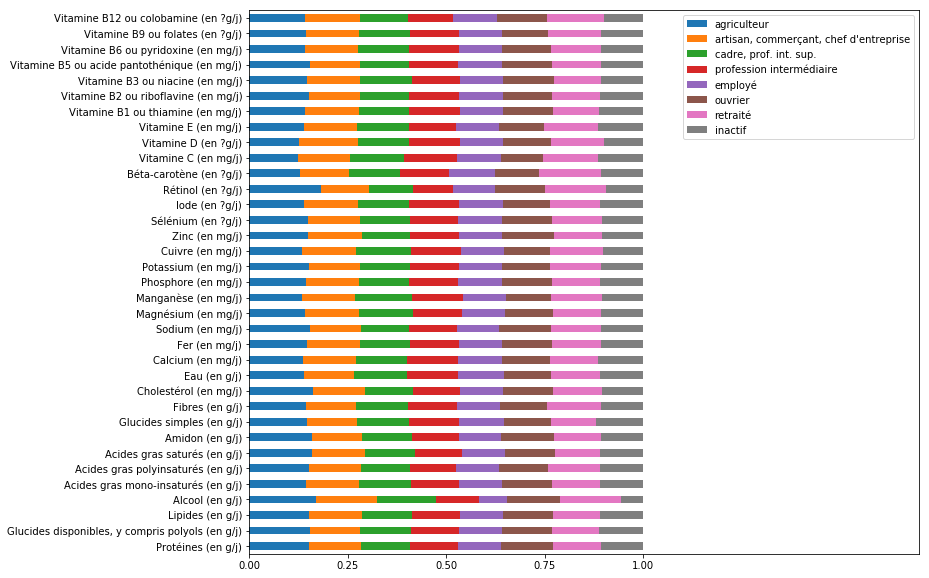

In [13]:
exploreNut_compareMeans("cspi2")

In [14]:
def exploreNut_allMeans(varOfInterest, references=False):
    """For each feature, plot the daily consumption, using varOfInterest to separate the indiduals in different groups"""
    # Create a
    dfNutIndivO18 = dfIndnut.merge(dfIndivO18, left_on="nomen", right_on="nomen", how="inner")
    numFeatures = ["nutj{}".format(i) for i in range(4, 29)]\
                 + ["nutj{}".format(i) for i in range(30, 40)]\
                 + ["bmi", "intense_j", "modere_j", "marche_j"]
    featuresNames = mapDescription(numFeatures)
    nutMeans = dfNutIndivO18.groupby(varOfInterest).mean()[numFeatures]
    nutMeans.columns = featuresNames
    # UNUSED: nutMeans.index = mapCorrespondances(nutMeans.index, varOfInterest)
    # Display the correspondances between codes and meanings
    print(dfDataCorrespondance[dfDataCorrespondance["Nom de la variable"] == varOfInterest][["code", "Signification"]])
    # Plot settings
    nb_col = 2
    nb_rows = len(featuresNames)//nb_col + len(featuresNames)%nb_col
    fig, axes = plt.subplots(nrows=nb_rows, ncols=nb_col, figsize = (nb_col*8, nb_rows*6))
    i = 0
    # Plot each feat
    for feat in numFeatures:
        featName = findDescription(feat)
        nutMeans[featName].plot(kind='barh', ax = axes[i//nb_col, i%nb_col], label = '')
        axes[i//nb_col, i%nb_col].set_title(featName)
        
        # 
        if references:
            if feat in dfValRef["Nom de la variable"].values:
                refH = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_homme"].values[0]
                refF = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_femme"].values[0]
                if str(refH) != 'nan':
                    ref = 0.5*refH + 0.5*refF
                    axes[i//nb_col, i%nb_col].plot([ref, ref],[-10,+10], 'g--', label=('Reference Value\\n(both genders)'))
                else:
                    axes[i//nb_col, i%nb_col].plot([0, 0],[0,0], 'g--', label=('No reference available'))
            else:
                axes[i//nb_col, i%nb_col].plot([0, 0],[0,0], 'g--', label=('No reference available'))
            axes[i//nb_col, i%nb_col].legend(loc = 1)
        # Increment i to plot in the next frame
        i += 1
    # Display
    plt.tight_layout()
    plt.show()

In [15]:
def exploreNut_allMeans_Genders(varOfInterest):
    """Brutal"""
    dfNutIndivO18 = dfIndnut.merge(dfIndivO18, left_on="nomen", right_on="nomen", how="inner")
    numFeatures = ["nutj{}".format(i) for i in range(4, 29)]\
                 + ["nutj{}".format(i) for i in range(30, 40)]\
                 + ["bmi", "intense_j", "modere_j", "marche_j"]
    featuresNames = mapDescription(numFeatures)
    nutMeans = dfNutIndivO18.groupby(["sexeps", varOfInterest]).mean()[numFeatures]
    nutMeans.columns = featuresNames
    print(dfDataCorrespondance[dfDataCorrespondance["Nom de la variable"] == "sexeps"][["code", "Signification"]])
    print(dfDataCorrespondance[dfDataCorrespondance["Nom de la variable"] == varOfInterest][["code", "Signification"]])
    nb_col = 2
    nb_rows = len(featuresNames)//nb_col + len(featuresNames)%nb_col
    fig, axes = plt.subplots(nrows=nb_rows, ncols=nb_col, figsize = (nb_col*8, nb_rows*6))
    i = 0
    for feat in numFeatures:
        featName = findDescription(feat)
        nutMeans[featName].plot(kind='barh', ax = axes[i//nb_col, i%nb_col], label = '')
        axes[i//nb_col, i%nb_col].set_title(featName)
        if feat in dfValRef["Nom de la variable"].values:
            refH = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_homme"].values[0]
            refF = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_femme"].values[0]
            if str(refH) != 'nan':
                axes[i//nb_col, i%nb_col].plot([refH, refH],[-20,+20], 'r-', label=('Reference Value\\n(men)'))
                axes[i//nb_col, i%nb_col].plot([refF, refF],[-20,+20], 'b--', label=('Reference Value\\n(women)'))
            else:
                axes[i//nb_col, i%nb_col].plot([0, 0],[0,0], 'g--', label=('No reference available'))
        else:
            axes[i//nb_col, i%nb_col].plot([0, 0],[0,0], 'g--', label=('No reference available'))
        axes[i//nb_col, i%nb_col].legend(loc = 1)
        i += 1
    plt.tight_layout()
    plt.show()

In [16]:
def exploreNut_allMeans_1Gender(varOfInterest, selected_gender = 1):
    """Brutal"""
    dfNutIndivO18 = dfIndnut.merge(dfIndivO18, left_on="nomen", right_on="nomen", how="inner")
    dfNutIndivO18 = dfNutIndivO18[dfNutIndivO18["sexeps"] == selected_gender]
    numFeatures = ["nutj{}".format(i) for i in range(4, 29)]\
                 + ["nutj{}".format(i) for i in range(30, 40)]\
                 + ["bmi", "intense_j", "modere_j", "marche_j"]
    featuresNames = mapDescription(numFeatures)
    nutMeans = dfNutIndivO18.groupby(["sexeps", varOfInterest]).mean()[numFeatures]
    nutMeans.columns = featuresNames
    print(dfDataCorrespondance[dfDataCorrespondance["Nom de la variable"] == "sexeps"][["code", "Signification"]])
    print(dfDataCorrespondance[dfDataCorrespondance["Nom de la variable"] == varOfInterest][["code", "Signification"]])
    if selected_gender == 1:
        gender_string = 'homme'
    else:
        gender_string = 'femme'
    nb_col = 2
    nb_rows = len(featuresNames)//nb_col + len(featuresNames)%nb_col
    fig, axes = plt.subplots(nrows=nb_rows, ncols=nb_col, figsize = (nb_col*8, nb_rows*6))
    i = 0
    for feat in numFeatures:
        featName = findDescription(feat)
        nutMeans[featName].plot(kind='barh', ax = axes[i//nb_col, i%nb_col], label = '')
        axes[i//nb_col, i%nb_col].set_title(featName)
        if feat in dfValRef["Nom de la variable"].values:
            ref = dfValRef[dfValRef["Nom de la variable"] == feat]["ValRef_"+gender_string].values[0]
            if str(ref) != 'nan':
                axes[i//nb_col, i%nb_col].plot([ref, ref],[-20,+20], 'g--', label=('Reference Value\\n'+gender_string))
            else:
                axes[i//nb_col, i%nb_col].plot([0,0],[0,0], 'g--', label=('No reference available'))
        else:
            axes[i//nb_col, i%nb_col].plot([0,0],[0,0], 'g--', label=('No reference available'))
        axes[i//nb_col, i%nb_col].legend(loc = 1)
        i += 1
    plt.tight_layout()
    plt.show()

      code                           Signification
3158     0                                   refus
3159     1                             agriculteur
3160     2  artisan, commerçant, chef d'entreprise
3161     3                  cadre, prof. int. sup.
3162     4                profession intermédiaire
3163     5                                 employé
3164     6                                 ouvrier
3165     7                                retraité
3166     8                                 inactif


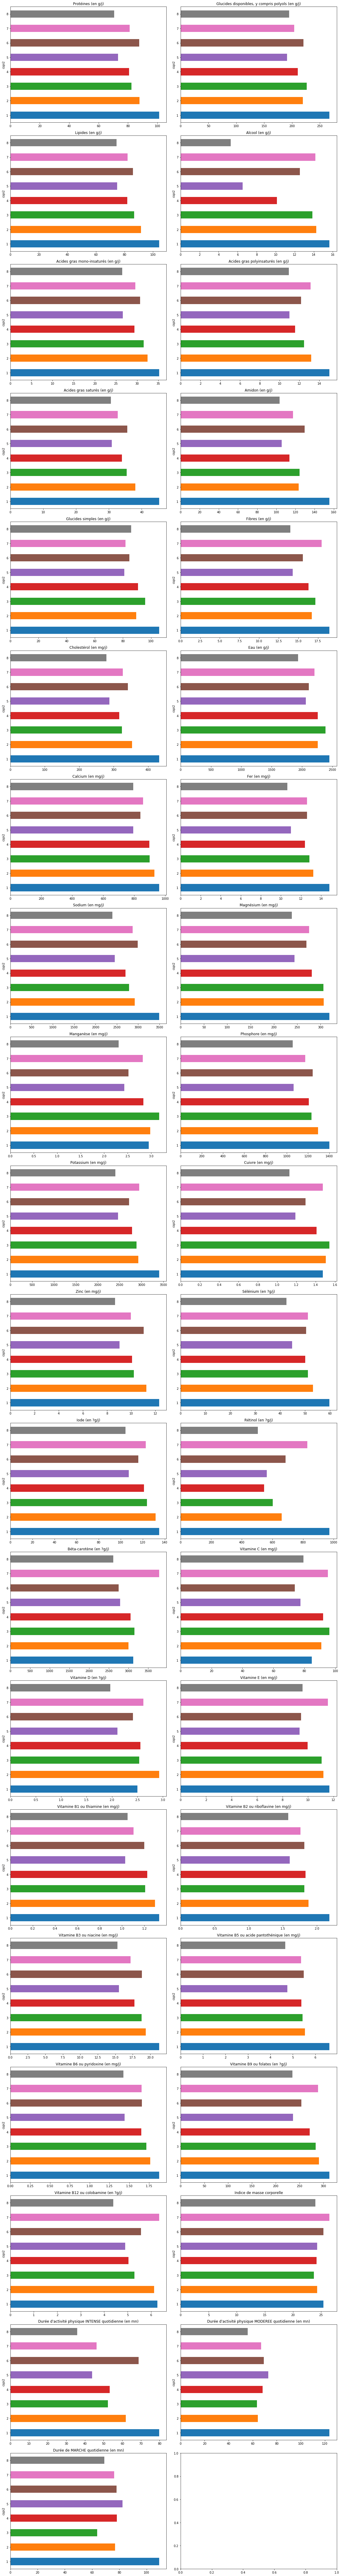

In [19]:
exploreNut_allMeans("cspi2")

      code Signification
2973     1         homme
2974     2         femme
      code                           Signification
3158     0                                   refus
3159     1                             agriculteur
3160     2  artisan, commerçant, chef d'entreprise
3161     3                  cadre, prof. int. sup.
3162     4                profession intermédiaire
3163     5                                 employé
3164     6                                 ouvrier
3165     7                                retraité
3166     8                                 inactif


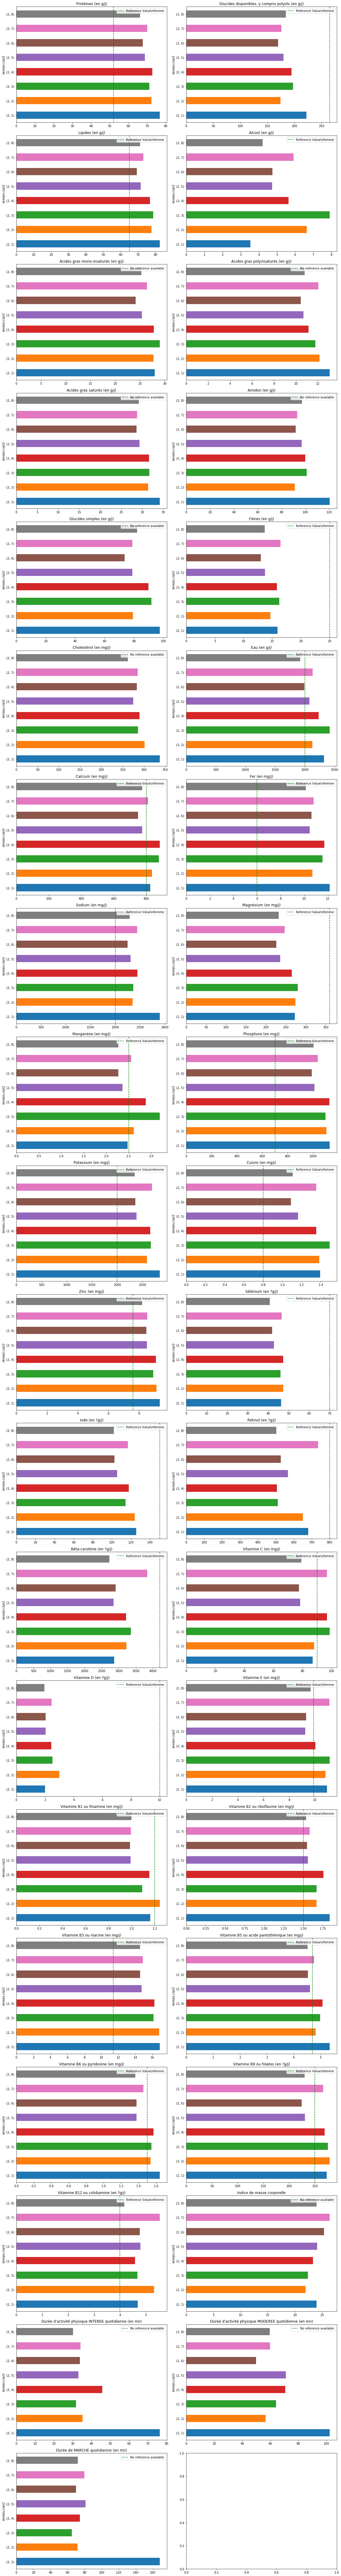

In [17]:
exploreNut_allMeans_Genders("cspi2")

      code Signification
2973     1         homme
2974     2         femme
      code           Signification
1281     1                   rural
1282     2      2 000 à 5 000 hab.
1283     3     5 000 à 10 000 hab.
1284     4    10 000 à 20 000 hab.
1285     5    20 000 à 50 000 hab.
1286     6   50 000 à 100 000 hab.
1287     7  100 000 à 200 000 hab.
1288     8          > 200 000 hab.
1289     9             agglo paris


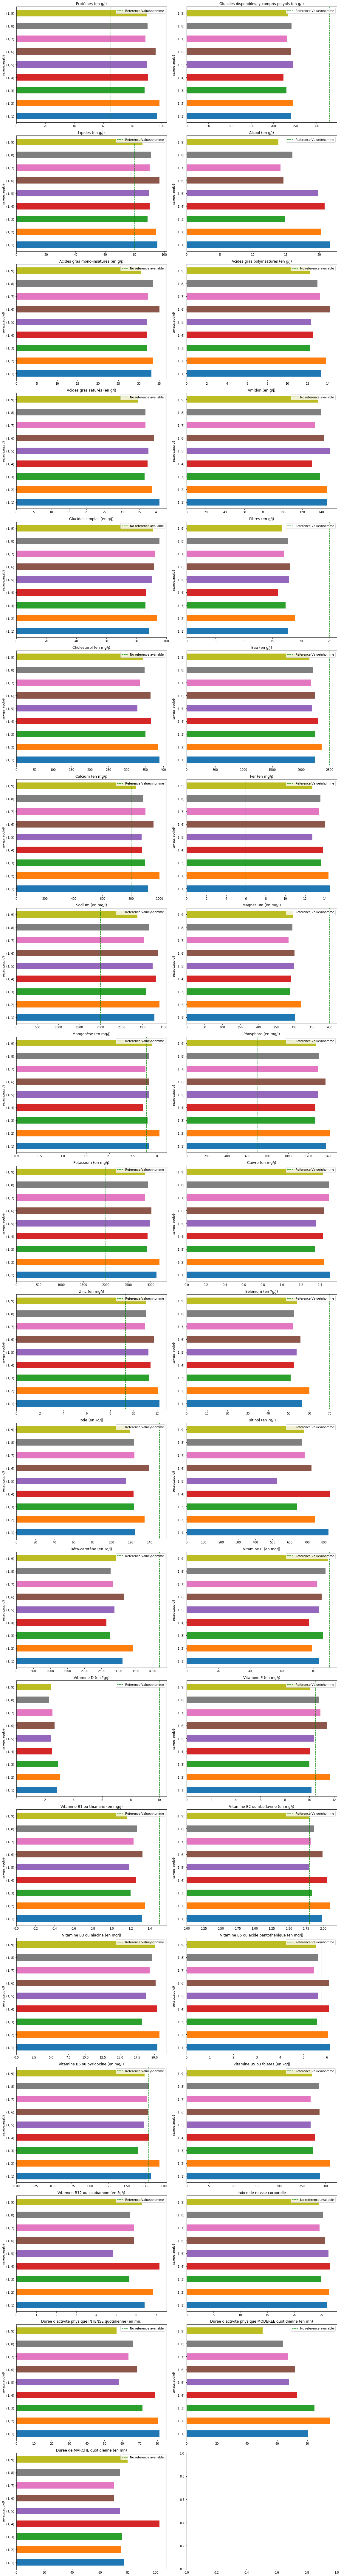

In [18]:
exploreNut_allMeans_1Gender("cspi2", 2)

In [ ]:
marqCounts = dfConso\
    .groupby("libmarq")\
    .agg({"codal": "count"}, as_index=False)\
    .rename(columns={"codal": "count"})\
    .sort_values("count", ascending=False)
marqCounts

In [ ]:
print("Brands with more than one item: {} / {}".format(len(marqCounts[marqCounts["count"] > 1]), len(marqCounts)))

In [ ]:
df = dfIndiv.merge(dfConso, left_on="nomen", right_on="nomen", how="inner")
dfBrands = df.groupby(["dip", "libmarq"], as_index=False).agg({"codal": "count", "qte_nette": "sum"}).rename(columns={"codal": "count"})
#dfBrands = dfBrands[dfBrands["count"] > 3]

diplomes = df["dip"].unique()
feature = "qte_nette"

for diplome in diplomes:
    fig, ax = plt.subplots()
    dfBrandsDiplomes = dfBrands[dfBrands.dip == diplome].sort_values(feature, ascending=False)
    ax.pie(x = dfBrandsDiplomes[feature][1:12], labels = dfBrandsDiplomes.libmarq[1:12])
    ax.axis("equal")
    ax.set_title("{} ({} Ind.) ({} alims)".format(findCorrespondance(diplome, "dip"), dfIndiv[dfIndiv["dip"] == diplome].shape[0], dfBrandsDiplomes["count"][1:12].sum()))
plt.show()

# Openfoodfacts

In [ ]:
result = json.load(urlopen(OFF_API_PATH.format("brands")))

In [ ]:
df = pd.DataFrame.from_records(result["tags"])
df.head(10).plot.bar(x="id", y="products")
plt.show()

In [ ]:
def getOFFDataFrame(adress, path = OFF_API_PATH):
    """
    Queries OFF database with local adress contained in adress. Formatting url is contained in path.
    """
    result = json.load(urlopen(path.format(adress)))
#     print("{} entries gathered".format(result["count"]))
    if "products" in result:
        return pd.DataFrame(result["products"])
    return pd.DataFrame(result["tags"])

def getOFFDataFrameDict(qdict, n = 1000):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    return getOFFDataFrame(q, OFF_API_QUERY_PATH)

def getOFFDataFrameDictAux(qdict, n = 1000, log=False):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    i = 1
    dfs = []
    nbCurr = -1
    nbSamples = 0
    while (nbCurr != 0) & (nbSamples < n):
        dfs.append(getOFFDataFrame(q + "&page=" + str(i), OFF_API_QUERY_PATH))
        nbCurr = dfs[-1].shape[0]
        nbSamples += nbCurr
        i += 1
        if log: 
            print("{} samples gathered.".format(nbSamples))
    return pd.concat(dfs).head(n)

def getOFFDataFrameCat(tags=[], nutriments=[], n = 1000, log=False, **kwargs):
    """
    Queries the OFF data base with query informations contained in tags and nutriments. 
    <ul>
        <li>Tags should be a list of lists of shape: 
        [tag, value, &lt;conatins&gt;] where tag is the category of tag (ex. "brands") and value, the value to 
        be searched (ex. "Carrefour")</li>
        <li>Nutriments should be a list of lists of shape: [nutriment, comparison, value] where nutriment is the name of the nutriment to be 
        searched (ex. "magnesium"), comparison the nature of the comparison (ex. "lte") and 
        value the value to be compared with (ex. 50)</li>
    </ul>
    """
    qdict = {}
    qdict.update(parseTags(tags))
    qdict.update(parseNutriments(nutriments))
    qdict.update(kwargs)
    
    return getOFFDataFrameDictAux(qdict, n, log)

def parseTags(tags):
    """
    Converts tags into an appropriate dictionary like shape
    """
    qdict = {}
    for i, tagsEl in enumerate(tags):
        if len(tagsEl) == 2:
            contains = True
        else:
            contains = tagsEl[2]
        qdict["tagtype_{}".format(i)] = tagsEl[0]
        qdict["tag_contains_{}".format(i)] = ["does_not_contain","contains"][int(contains)]
        qdict["tag_{}".format(i)] = tagsEl[1]
    return qdict

def parseNutriments(nutriments):
    """
    Converts nutriments into an appropriate dictionary like shape
    """
    qdict = {}
    for i, nutrimentsEl in enumerate(nutriments):
        qdict["nutriment_{}".format(i)] = nutrimentsEl[0]
        qdict["nutriment_compare_{}".format(i)] = nutrimentsEl[1]
        qdict["nutriment_value_{}".format(i)] = nutrimentsEl[2]
        nutriment_i += 1
    return qdict

In [ ]:
help(getOFFDataFameCat)

In [ ]:
labelsDf = getOFFDataFrame("labels")
labelsDf = labelsDf.sort_values("products", ascending=False)

In [ ]:
df = labelsDf.head(15)
df.plot.pie(labels=df["name"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

In [ ]:
organicBrandsDf = getOFFDataFrame("label/organic/brands")
organicBrandsDf = organicBrandsDf.sort_values("products", ascending=False)
df = organicBrandsDf.head(15)
df.plot.pie(labels=df["name"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

In [ ]:
organicBrandsDf = getOFFDataFrameDict({"tagtype_0": "labels", "tag_contains_0": "contains","tag_0": "organic"})


In [ ]:
organicBrand = organicBrandsDf.copy()
organicBrand["brand"] = organicBrand["brands"].str.split(pat =",", expand=True)[0]
organicBrand = organicBrand.groupby("brand").agg({"brand": "max", "_id": "count"}).rename(columns = {"_id":"products"})
organicBrand = organicBrand.sort_values("products", ascending=False)
df = organicBrand.head(15)
df.plot.pie(labels=df["brand"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

In [ ]:
organicBrandsDf = getOFFDataFrameCat(tags = [["labels", "organic"]])
organicBrand = organicBrandsDf.copy()
organicBrand["brand"] = organicBrand["brands"].str.split(pat =",", expand=True)[0]
organicBrand = organicBrand.groupby("brand").agg({"brand": "max", "_id": "count"}).rename(columns = {"_id":"products"})
organicBrand = organicBrand.sort_values("products", ascending=False)
df = organicBrand.head(15)
df.plot.pie(labels=df["brand"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

In [ ]:
organicDf = getOFFDataFrameCat(tags = [["labels", "organic"]], n= 20000, log=True)
nonOrganicDf = getOFFDataFrameCat(tags = [["labels", "organic", False]], n=30000, log=True)

In [ ]:
def getCategories(df, minlength=4, maxlength=20):
    cats = pd.DataFrame([x.lower() for cats in df["categories"] for x in re.split("\W", str(cats))], columns=["categories"])
    return cats[cats["categories"].apply(lambda x: (len(x) >= minlength) & (len(x) <= maxlength))]

def generateWordCloud(df, stopwordsAdd={}, **kwargs):
    stopwords = set(STOPWORDS)
    stopwords.update(stopwordsAdd)
    kwargsWC = {"background_color":"white", "stopwords":stopwords, "width":720, "height":480, "margin":0, "colormap":"inferno"}
    kwargsWC.update(kwargs)
    categories = getCategories(nonOrganicDf)
    categoriesText = " ".join(categories["categories"])
    
    wc = WordCloud(**kwargsWC).generate(categoriesText)

    # Display the generated image:
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

stopwords = {"base", "based", "origine"}
generateWordCloud(organicDf, stopwords, colormap = "viridis")
generateWordCloud(nonOrganicDf, stopwords, colormap = "inferno")

In [ ]:
def printColumns(table):
    for x in table.columns:
        print(x)


In [ ]:
printColumns(organicDf)

In [ ]:
def toFloat(x):
    try:
        return float(x)
    except:
        return np.nan

In [ ]:
cats = ["pain", "bread", "mie"]
catOrganic = organicDf[organicDf["_keywords"].apply(lambda x: contains(cats, x))]
catNOrganic = nonOrganicDf[organicDf["_keywords"].apply(lambda x: contains(cats, x))]

In [ ]:
energy = organicDf["nutriments"].apply(lambda x: toFloat(x.setdefault("energy_100g", 0))).dropna()
energy = energy[energy < 4000]
print(energy.describe())
energy.hist()
plt.show()

In [ ]:
def gatherNutriments(df, nutriment, p=5):
    vals = df["nutriments"].apply(lambda x: toFloat(x.setdefault("{}_100g".format(nutriment), 0))).dropna().values
    vMin = np.percentile(vals, p)
    vMax = np.percentile(vals, 100 - p)
    return vals[(vals >= vMin) & (vals <= vMax)]

In [ ]:
cats = ["céréales"]
catOrganic = organicDf[organicDf["categories"].apply(lambda x: contains(cats, str(x)))]
catNOrganic = nonOrganicDf[nonOrganicDf["categories"].apply(lambda x: contains(cats, str(x)))]
nutriments = ["energy","energy-from-fat","fat","saturated-fat","butyric-acid","caproic-acid","caprylic-acid","capric-acid","lauric-acid","myristic-acid","palmitic-acid","stearic-acid","arachidic-acid","behenic-acid","lignoceric-acid","ceroticacid","montanic-acid","melissic-acid","monounsaturated-fat","polyunsaturated-fat","omega-3-fat","alpha-linolenic-acid","eicosapentaenoic-acid","docosahexaenoic-acid","omega-6-fat","linoleic-acid","arachidonic-acid","gamma-linoleni-acid","dihomo-gamma-linolenic-acid","omega-9-fat","oleic-acid","elaidic-acid","gondoic-acid","mead-acid","erucic-acid","nervonic-acid","trans-fat","cholesterol","carbohydrates","sugars","sucrose","glucose","fructose","lactose","maltose","maltodextrins","starch","polyols","fiber","proteins","casein","serum-proteins","nucleotides","salt","sodium","alcohol","vitamin-a","beta-carotene","vitamin-d","vitamin-e","vitamin-k","vitamin-c","vitamin-b1","vitamin-b2","vitaminpp","vitamin-b6","vitamin-b9","vitamin-b12","biotin","pantothenic-acid","silica","bicarbonate","potassium","chloride","calcium","phosphorus","iron","magnesium","zinc","copper","manganese","fluoride","selenium","chromium","molybdenum","iodine","caffeine","taurine","ph","fruits-vegetables-nuts","collagen-meat-protein-ratio","cocoa","chlorophyl","carbon-footprint","nutrition-score-fr","nutrition-score-uk"]
# nutriments = ["energy","vitamin-a","beta-carotene","vitamin-d","vitamin-e","vitamin-k","vitamin-c","vitamin-b1","vitamin-b2","vitaminpp","vitamin-b6","vitamin-b9","vitamin-b12"]
for nutriment in nutriments:
    orgNut = gatherNutriments(catOrganic, nutriment)
    nOrgNut = gatherNutriments(catNOrganic, nutriment)
    print("{: <40}{}".format(nutriment, ttest_ind(orgNut, nOrgNut).pvalue))
    if (np.mean(orgNut) > 0) &  (np.mean(nOrgNut) > 0):
        plt.figure(figsize=(10, 4))
        plt.hist([orgNut, nOrgNut], density=True, bins=50, histtype ="stepfilled", alpha=0.5)
        plt.legend(["organic", "non organic"])
        plt.title(nutriment)
plt.show()

In [ ]:
organicCategories = pd.DataFrame([x.lower() for cats in organicDf["categories"] for x in re.split("[ ,]", str(cats))], columns=["categories"])
organicCategories[organicCategories["categories"].apply(lambda x: len(x) > 2)].groupby("categories").agg({"categories": "count"}).sort_values("categories", ascending=False)

In [ ]:
nonOrganicCategories = pd.DataFrame([x.lower() for cats in nonOrganicDf["categories"] for x in re.split("[ ,]", str(cats))], columns=["categories"])
nonOrganicCategories[nonOrganicCategories["categories"].apply(lambda x: len(x) > 2)].groupby("categories").agg({"categories": "count"}).sort_values("categories", ascending=False)

In [ ]:
categories["categories"].apply(lambda x: len(x) > 2)

In [ ]:
def contains(strList, container):
    for s in strList:
        if s in container:
            return True
    return False

def showCols(table):
    for x in table.columns:
        print(x)

nonOrganicDf["category"] = nonOrganicDf["categories"].str.split(',', expand=True)[0]
nonOrganicDf[nonOrganicDf["_keywords"].apply(lambda x: contains(["pain", "bread", "mie"], x))][["generic_name", "brands"]]

In [ ]:
organicDf[organicDf["_keywords"].apply(lambda x: contains(["pain", "bread", "mie"], x))][["generic_name", "brands"]]

In [ ]:
showCols(nonOrganicDf)

In [ ]:
countriesDf = getOFFDataFrame("countries")
countriesDf = countriesDf.sort_values("products", ascending=False)

In [ ]:
df = countriesDf.head(15)
df.plot.bar(x="name", y="products", legend=False, log=True)
plt.title("Top 15 sales countries")
plt.show()

In [ ]:
ingredientsDf = getOFFDataFrame("nutrient-levels")
ingredientsDf = ingredientsDf.sort_values("products", ascending=False)
ingredientsDf

In [ ]:
ingDf = ingredientsDf.head(15)
ingDf.plot.bar(x="name", y="products", legend=False)
plt.title("Top 15 sales countries")
plt.show()

In [ ]:
result = json.load(urlopen(OFF_API_PATH.format("country/france/2")))
for k, v in result.items():
    try:
        print(k, len(v))
    except:
        print(k, v)

In [ ]:
def findKey(data):
    for k, v in data.items():
        if isinstance(v, list):
            return k

def gatherOFFDataFramePages(adress, pages = None):
    result = json.load(urlopen(OFF_API_PATH.format(adress)))
    count = result["count"]
    key = findKey(result)
    df = pd.DataFrame(result[key])
    if "page" in result.keys():
        nbPages = (count - 1) // result["page_size"] + 1
        if pages != None:
            nbPages = np.min([nbPages, pages])
        for i in range(2, nbPages+1):
            currResult = json.load(urlopen(OFF_API_PATH.format(adress + "/" + str(i))))
            currDf = pd.DataFrame(currResult[key])
            df = df.append(currDf, sort=False)
            print(i, df["_id"].count())
    return df

In [ ]:
franceDf = gatherOFFDataFramePages("country/france", 5)
franceDf[["_id", "product_name", "labels", "ingredients_text", "last_modified_t", "brands"]].head(100)

In [ ]:
for x in franceDf.columns:
    print(x)

In [ ]:
spark = SparkSession.builder.getOrCreate()
sqlContext = sqlContext = SQLContext(spark)

In [ ]:
DATA_DIR = "../data/"
if os.path.exists(DATA_DIR+"openfoodfacts.parquet"):
    productsDf = spark.read.parquet(DATA_DIR + "openfoodfacts.parquet")
    #productsDf.show(2)
else:
    productsDf = spark.read.csv(DATA_DIR+'en.openfoodfacts.org.products.csv', header=True, sep="	") #load the dataset into a Spark dataframe
    #productsDf.show(2) #show the content (20 first rows)
    productsDf.write.parquet(DATA_DIR+"openfoodfacts.parquet", mode="overwrite") #save it in the Parquet format

for (k, v) in productsDf.dtypes:
    print("{: <20}:{}".format(k, v))

In [ ]:
dfConsoAll = dfConso.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")

In [ ]:
def plotBar(table, idx, col, x):
    consos = table[[col, idx, x]].groupby([idx, col]).count().unstack(level=1)[x]
    consos = consos.swapaxes(0,1)
    consos = consos / consos.sum(axis=0)
    consos = consos.swapaxes(0,1)
    consos.index = mapCorrespondances(consos.index, idx)
    consos.columns = mapCorrespondances(consos.columns, col)
    consos.plot.bar(stacked=True)
    plt.show()

def plotScatter(table, col1, col2):
    data = table[[col1, col2]].values
    plt.scatter(data[:,0], data[:,1])
    plt.show()
    
def getBinsFunc(x, nbins):
    xmin = np.min(x)
    xmax = np.max(x) * 1.01
    return lambda v: np.int16(nbins * (v - xmin) / (xmax - xmin)) * (xmax - xmin) + xmin
    
def plotScatterCateX(table, x, y, index, bins):
    consos = table[[x, y, index]]
    f = getBinsFunc(consos[y], bins)
    consos[y] = f(consos[y])
    plotBar(consos, x, y, index)
    

In [ ]:
plotBar(dfConsoAll, "tage", "typal3", "numlig")

In [ ]:
plotBar(dfConsoAll, "tage", "tyrep", "numlig")

In [ ]:
plotBar(dfIndiv, "tage", "essaipds", "nomen")

In [ ]:
plotBar(dfIndiv, "sexe_ps", "essaipds", "nomen")

In [ ]:
plotBar(dfIndiv, "tage", "opipoids", "nomen")

In [ ]:
plotBar(dfIndiv, "sexe_ps", "opipoids", "nomen")

In [ ]:
plotScatterCateX(dfIndiv, "sexe_ps", "modere_hebdo", "nomen", 5)

# Inference

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def plotPCAComponents(table, features, trainIndex = None, nbComps=4):
    # Train PCA
    data = table[features].values
    
    if trainIndex is None:
        trainIndex = np.ones(len(data), "bool")

    trainData = data[trainIndex]

    mu = np.mean(trainData, axis=0)
    sigma = np.std(trainData, axis=0)

    trainData = (trainData - mu) / sigma

    pca = PCA()
    pca.fit(trainData)
    
    #Show PCA first comps
    featuresNames = mapDescription(features)
    
    cumComponents = np.zeros(len(features))
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(nbComps):
        components = np.abs(pca.components_[i, :])
        ax.bar(featuresNames, components, bottom=cumComponents)
        cumComponents += components
    plt.xticks(fontsize=12, rotation=90)
    plt.show()

In [ ]:
def plotMeanValues(table, features, className, mincount=50):
    featuresNames = mapDescription(features)

    means = table.groupby(className).filter(lambda x: len(x) > mincount).groupby(className).mean()[features]
    means.columns = featuresNames
    means /= means.sum(axis=0)
    means = means.swapaxes(0, 1)
    means.columns = mapCorrespondances(means.columns, className)
    means.plot.bar(stacked=True, figsize=figsize)
    plt.show()

In [ ]:
table = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
className = "tage"
samples = "nomen"
cateFeatures = []
numFeatures = np.array(["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)])
featuresNames = mapDescription(numFeatures)

data = table[numFeatures].values
labels = table[className].values

trainIndex = np.ones(len(data), "bool")
trainIndex[np.arange(int(len(data) * 0.8))] = False

trainData = data[trainIndex]
testData = data[~trainIndex]
trainLabels = labels[trainIndex]
testLabels = labels[~trainIndex]

mu = np.mean(trainData, axis=0)
sigma = np.std(trainData, axis=0)

trainData = (trainData - mu) / sigma
testData = (testData - mu) / sigma


pca = PCA()
pca.fit(trainData)

In [ ]:
nbComps = 3
cumComponents = np.zeros(len(numFeatures))
fig, ax = plt.subplots(figsize=figsize)
for i in range(nbComps):
    components = np.abs(pca.components_[i, :])
    ax.bar(featuresNames, components, bottom=cumComponents)
    cumComponents += components
plt.xticks(fontsize=12, rotation=90)
plt.show()

In [ ]:
indnutIndTable = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
columns = {col:col[:-2] for col in indnutIndTable.columns if col[-2:] == "_x"}
dropColumns = [col for col in indnutIndTable.columns if col[-2:] == "_y"]
indnutIndTable = indnutIndTable.rename(columns = columns).drop(columns= dropColumns)

In [ ]:
plotPCAComponents(indnutIndTable, numFeatures, nbComps=3)

In [ ]:
className = "agglo9"
samples = "nomen"
cateFeatures = []
numFeatures = ["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)] + ["poidsm", "taille", "v2_age", "tele", "intense_j", "modere_j", "marche_j"]
featuresNames = mapDescription(numFeatures)

table = indnutIndTable
means = table.groupby(className).mean()[numFeatures]
means.columns = featuresNames
means /= means.sum(axis=0)
means = means.swapaxes(0, 1)
means.columns = mapCorrespondances(means.columns, className)
means.plot.bar(stacked=True, figsize=figsize)
plt.show()

In [ ]:
x = "tage"
df = dfIndiv.groupby(x).agg({"nomen": "count"})
df.index = mapCorrespondances(np.int8(df.index), x)
df

In [ ]:
df = dfIndiv.groupby("v2_age").agg({"v2_age":"max", "nomen": "count"}).rename(columns={"nomen": "count"})
df.plot("v2_age", "nomen")
plt.xlabel("age")
plt.ylabel("count")
plt.show()

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "agglo9")

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "region")

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "tage")

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "fastfood")

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "situ_prof")

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "situ_mat")

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "loc_log")

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "fume")

In [ ]:
plotMeanValues(indnutIndTable, numFeatures, "sexe_ps")

In [ ]:
for col in indnutIndTable.columns:
    print(col)

In [ ]:
dfNomenclature.groupby("libgr").count()

In [ ]:
dfNomenclature

In [ ]:
dfConso